# The Burguer's Equation

$$
\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

In [2]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

In [3]:
class NN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(NN, self).__init__(*args, **kwargs)
        self.net = torch.nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [4]:
x = torch.arange(-1, 1 + 0.1, 0.1)
t = torch.arange(0, 1 + 0.1, 0.1)

print(x)
print(t)

tensor([-1.0000e+00, -9.0000e-01, -8.0000e-01, -7.0000e-01, -6.0000e-01,
        -5.0000e-01, -4.0000e-01, -3.0000e-01, -2.0000e-01, -1.0000e-01,
        -2.9802e-09,  1.0000e-01,  2.0000e-01,  3.0000e-01,  4.0000e-01,
         5.0000e-01,  6.0000e-01,  7.0000e-01,  8.0000e-01,  9.0000e-01,
         1.0000e+00])
tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])


In [5]:
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
print(X)

tensor([[-1.0000e+00,  0.0000e+00],
        [-1.0000e+00,  1.0000e-01],
        [-1.0000e+00,  2.0000e-01],
        [-1.0000e+00,  3.0000e-01],
        [-1.0000e+00,  4.0000e-01],
        [-1.0000e+00,  5.0000e-01],
        [-1.0000e+00,  6.0000e-01],
        [-1.0000e+00,  7.0000e-01],
        [-1.0000e+00,  8.0000e-01],
        [-1.0000e+00,  9.0000e-01],
        [-1.0000e+00,  1.0000e+00],
        [-9.0000e-01,  0.0000e+00],
        [-9.0000e-01,  1.0000e-01],
        [-9.0000e-01,  2.0000e-01],
        [-9.0000e-01,  3.0000e-01],
        [-9.0000e-01,  4.0000e-01],
        [-9.0000e-01,  5.0000e-01],
        [-9.0000e-01,  6.0000e-01],
        [-9.0000e-01,  7.0000e-01],
        [-9.0000e-01,  8.0000e-01],
        [-9.0000e-01,  9.0000e-01],
        [-9.0000e-01,  1.0000e+00],
        [-8.0000e-01,  0.0000e+00],
        [-8.0000e-01,  1.0000e-01],
        [-8.0000e-01,  2.0000e-01],
        [-8.0000e-01,  3.0000e-01],
        [-8.0000e-01,  4.0000e-01],
        [-8.0000e-01,  5.000

/home/thiago.esterci/.conda/envs/pyTourch/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
class Net:
    def __init__(self):
        device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

        self.model = NN().to(device)

        # comp. domain
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T

        # train data
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam = torch.optim.Adam(self.model.parameters())

        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
        )[0]

        # print(du_dX)
        # print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        # print(du_dX[0])

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs=torch.ones_like(du_dX),
            create_graph=True,
            retain_graph=True,
        )[0]

        du_dxx = du_dXX[:, 0]

        loss_pde = self.criterion(
            du_dt + u.squeeze() * du_dx, (0.01 / math.pi) * du_dxx
        )

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1

        return loss

    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [7]:
# Training

net = Net()

net.train()

100 0.16014571487903595
200 0.08762426674365997
300 0.06323512643575668
400 0.03905414044857025
500 0.0280085951089859
600 0.03260484337806702
700 0.0166110061109066
800 0.014469185844063759
900 0.012847904115915298
1000 0.011462617665529251
1100 0.006156953517347574
1200 0.0033241091296076775
1300 0.0017988095059990883
1400 0.0010188628220930696
1500 0.0006025205948390067
1600 0.0004522762028500438
1700 0.0003064365009777248
1800 0.00022160806111060083
1900 0.00017528064199723303
2000 0.00013698189286515117
2100 0.00011645376071101055
2200 0.00010323261085432023
2300 9.12505856831558e-05
2400 8.034240454435349e-05
2500 7.16502545401454e-05
2600 6.564869545400143e-05
2700 5.822969978908077e-05
2800 5.0978382205357775e-05
2900 4.604049172485247e-05
3000 4.351699317339808e-05
3100 4.068190901307389e-05
3200 3.8611000491073355e-05
3300 3.625279350671917e-05
3400 3.514363197609782e-05
3500 3.2890406146179885e-05
3600 3.1173858587862924e-05
3700 2.9636561521328986e-05
3800 2.831117672030814

In [8]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [9]:
h = 0.01
k = 0.01

x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [10]:
model = net.model

model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x), len(t)).cpu().numpy()

In [11]:
sns.set_style("white")
plt.figure(figsize=(5, 3), dpi=3000)
sns.heatmap(y_pred, cmap="jet")

<Axes: >

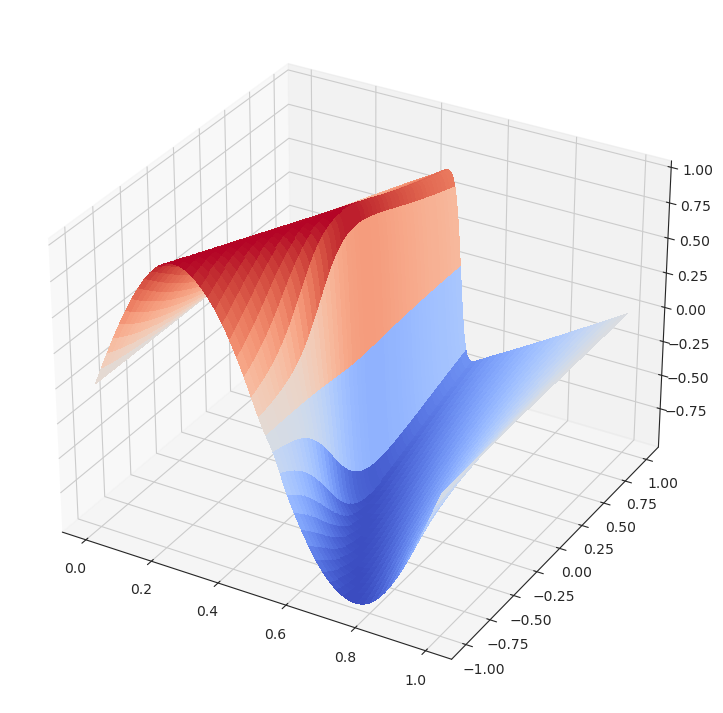

In [31]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figwidth(16)
fig.set_figheight(9)

x = np.linspace(-1, 1, 100, endpoint=True)
t = np.linspace(0, 1, 200, endpoint=True)

X, Y = np.meshgrid(t, x)

# Plot the surface.
surf = ax.plot_surface(X, Y, y_pred.T, cmap=cm.coolwarm, linewidth=0, antialiased=False)


fig.xlabel = "x"
fig.ylabel = "time"
fig.zlabel = "temperature"

plt.show()